In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# uses modified version of scanpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install leidenalg
import os, sys
%cd "/content/drive/MyDrive/Colab Notebooks/scanpy"
sys.path.append(os.getcwd())
import os
SCRIPT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/')
!pip install -e "/content/drive/MyDrive/Colab Notebooks/scanpy"
import scanpy as sc
import anndata as ann
import pandas as pd
import scipy.io
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import re
# INPUT_DATA = os.path.join(SCRIPT_DIR, "DATA","sc2")
DF_PROCESSEDv4_DATAPATH = os.path.join(SCRIPT_DIR, "DATA","DF","df_processedv4.h5ad")
FIGURE_DIR = os.path.join(SCRIPT_DIR, "Plots", "Initial_Clustering")
!pip freeze "/content/drive/MyDrive/Colab Notebooks/DATA/requirements.txt"

In [ ]:
plt.rcParams["figure.figsize"] = (9,9) 

scm_ml = ann.read(DF_PROCESSEDv4_DATAPATH)
scm_ml.obs['leiden'] = scm_ml.obs['leiden'].astype(int)

#  add columns for probability and cluster assignments (all zeroes for now)
t_final = scm_ml.obs['Timepoint'].max()
num_classes = len(scm_ml[scm_ml.obs['Timepoint'] == t_final].obs['leiden'].unique())
# Column 'p(ci)' represents probability that an observation belongs to cluster i at t_final
prob_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                       index=scm_ml.obs.index, 
                       columns=['p(c'+str(i)+')' for i in range(num_classes)])
# Column ci represents formal cell assignment, based off a later-specified p threshold of p(ci)
clust_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                                    index=scm_ml.obs.index, 
                                    columns=['c' + str(i) for i in range(num_classes)])
scm_ml.obs = pd.concat([scm_ml.obs,prob_df,clust_df],axis=1)

# Assign initial ci with 1's to signify a cell belongs to the last timepoint leiden clusters; rest will remain zero 
for clust_idx in clust_df:
  clust_num = int(clust_idx[1])
  f = (scm_ml.obs['leiden'] == clust_num) & (scm_ml.obs['Timepoint'] == t_final)
  scm_ml.obs.loc[f, clust_idx] = 1


In [ ]:
import time

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Trains binary classifier on provided cluster
def train_classifier(t2, scm, clust_idx, use_xgboost=True, method='exact', n_estimators=1000, max_depth=7):
  f2 = scm.obs['Timepoint'] == t2
  X2 = scm[f2].X
  y2 = (scm[f2]).obs[clust_idx]
  if use_xgboost:
    param_dist = {'method':'exact', 'n_estimators':n_estimators, 
                  'max_depth': max_depth, 'binary':'logistic'}
  else: #TODO: random forest classifier
    print("Random forest not implemented yet")
    return
  clf = XGBClassifier(**param_dist)
  start = time.time()
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.9, test_size=0.1, random_state=2)
  if len(y2_train.unique()) != len(y2_test.unique()):
    raise ValueError("Train and test labels do not overlap")
  clf.fit(X2_train, y2_train)
  plot_confusion_matrix(clf,X2_test,y2_test)
  end = time.time()
  print("Model split and trained using {} in {} seconds".format(method, end-start))
  return X2_train, X2_test, y2_train, y2_test, clf

def timepoint_probabilities(scm, tp, clust, plots, n_neighbors,min_dist, resolution):
  scm_n = scm[scm.obs['Timepoint'] == tp]
  start = time.time()
  sc.pp.neighbors(scm_n, n_neighbors,random_state=1)
  sc.tl.umap(scm_n, min_dist, n_components=2, random_state=1, alpha=1)
  plots.append(scm_n)
  stage = scm_n.obs['Stage'][0]
  sc.pl.scatter(scm_n, 
                title='Timepoint: {} ({}), cells: {}, NN= {}'.format(tp, stage ,scm_n.n_obs, n_neighbors),
                basis='umap', color='p(c' + str(clust) + ')', 
                save='_UMAP_CLUSTPROB_{}_TIMEPOINT_{}.png'.format(clust,tp))
  end = time.time()
  print("Time to visualize: "+ str(end-start) + " seconds")

Model split and trained using exact in 128.75411868095398 seconds


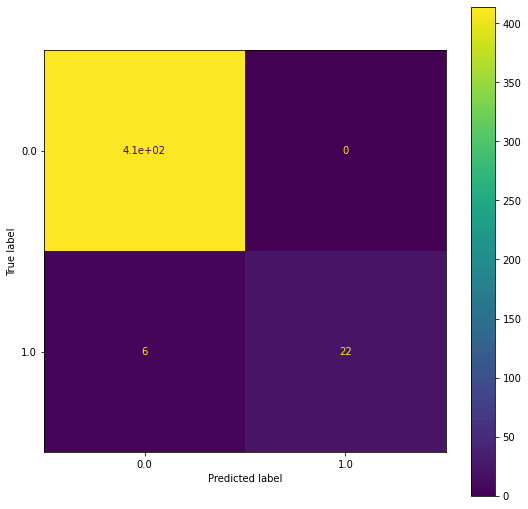

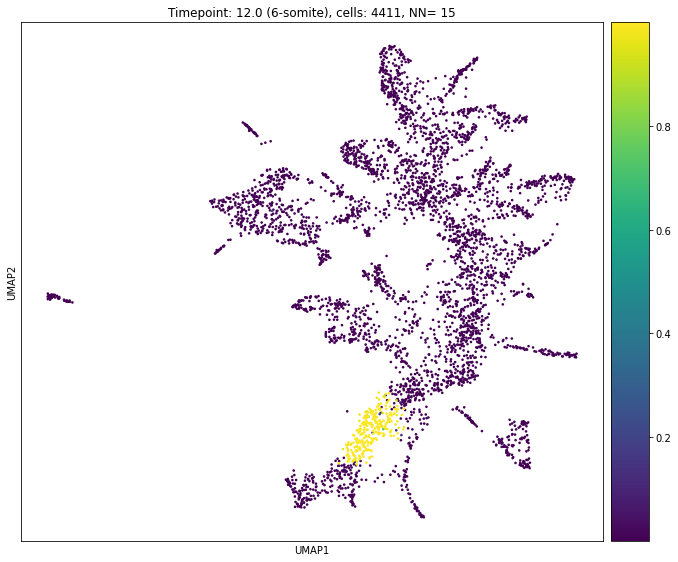

Time to visualize: 17.82385778427124 seconds


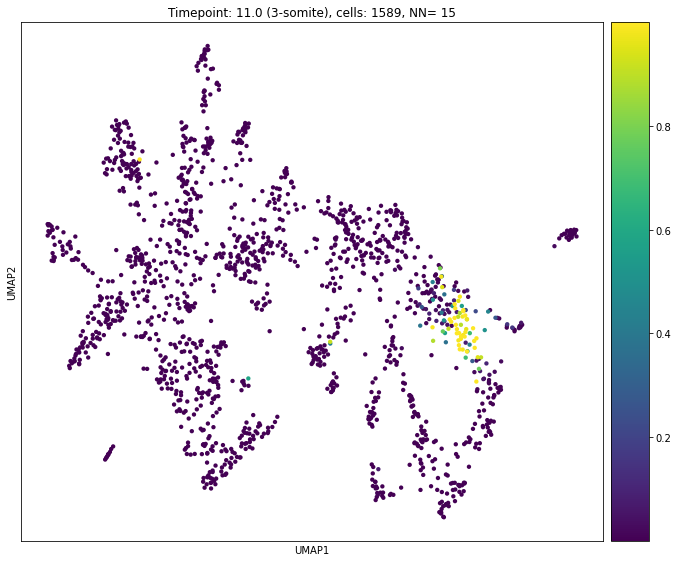

Time to visualize: 7.881530284881592 seconds
Model split and trained using exact in 27.296955823898315 seconds


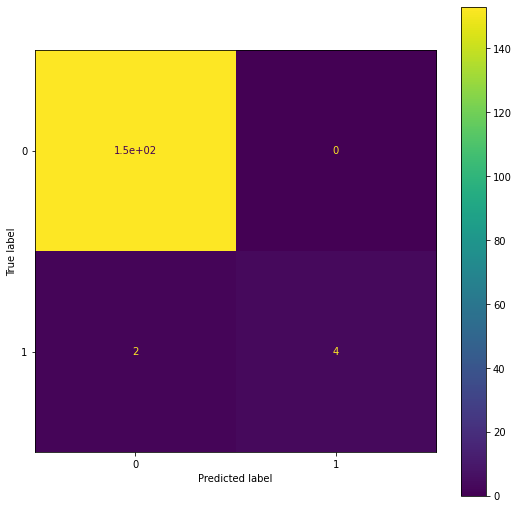

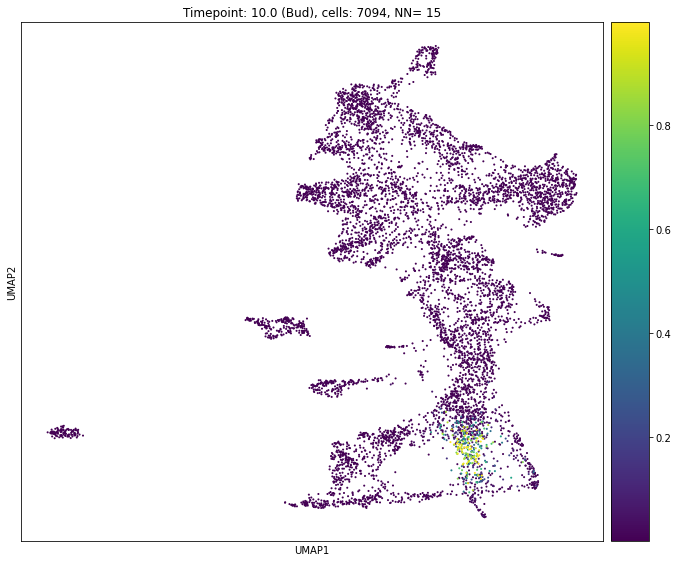

Time to visualize: 27.107041597366333 seconds
Model split and trained using exact in 169.43808603286743 seconds


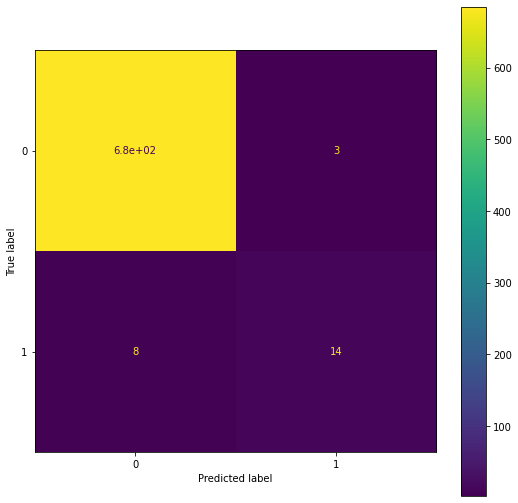

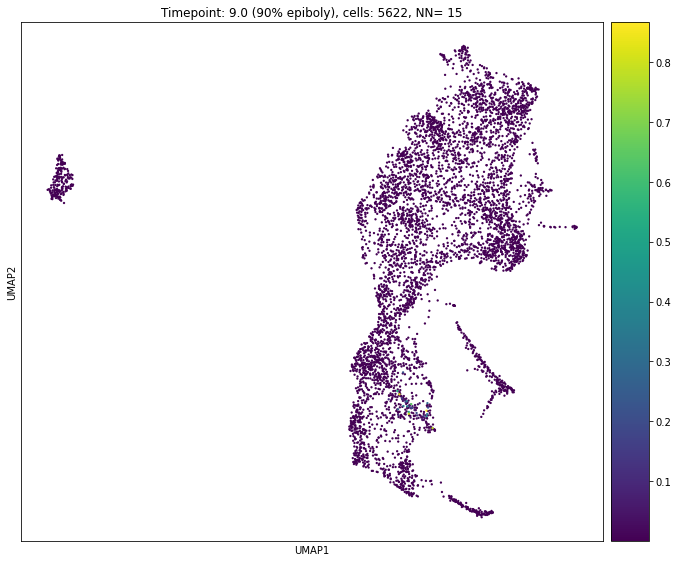

Time to visualize: 21.748104095458984 seconds


In [ ]:
timepoints = list(set(scm_ml.obs['Timepoint']))
timepoints.sort()
n_timepoints = len(set(scm_ml.obs['Timepoint']))
CLUST_IDS = [5]
p = 0.6
plots = []
for i in range(3):
  for clust_id in CLUST_IDS:      
    t2 = timepoints[-1*(i+1)]
    t1 = timepoints[-1*(i+2)]
    clust_idx = 'c' + str(clust_id)
    prob_idx = 'p(' + clust_idx + ')'
    X2_train, X2_test, y2_train, y2_test, clf = train_classifier(t2=t2, scm=scm_ml, clust_idx=clust_idx)
    labels = y2_test.unique()
    labels.sort()
    # y2_pred = clf.predict(X2_test)
    # prf = precision_recall_fscore_support(y_true=y2_test, y_pred=y2_pred, average=None, labels=labels)
    # P_IDX = 0
    # R_IDX = 1
    # train_threshold = 0.8
    # trust_arr=[]
    # def det_trust(arr):
    #   trust_arr.append(arr[P_IDX] >train_threshold and arr[R_IDX] > train_threshold)
    # np.apply_along_axis(det_trust, axis=0, arr=prf)
    # print(trust_arr)
    # TO DO: GRAPH BOOST AFTER EVERY ITERATION 
    if t2 == t_final:
      # Just for completion, assign probabilities for initial timepoint as well
      X_t2= scm_ml[scm_ml.obs['Timepoint'] == t2].X
      y_t2 = clf.predict_proba(X_t2)
      scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t2,prob_idx] = y_t2[:,1]
      timepoint_probabilities(scm_ml, t2, clust_id, plots, n_neighbors=15, min_dist=0.3, resolution=1)
      # don't need to change cluster assignments since we already did that for t_final
    X_t1= scm_ml[scm_ml.obs['Timepoint'] == t1].X
    y_t1 = clf.predict_proba(X_t1)
    # update new probabilities at t1
    scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1,prob_idx] = y_t1[:,1]
    # update specified cluster's assignments for t1
    scm_ml.obs[clust_idx] = np.where(scm_ml.obs[prob_idx] > p, 1, 0)
    scm_ml.obs.loc[(scm_ml.obs['Timepoint'] == t1) & (scm_ml.obs[prob_idx] > p), clust_idx] = 1
    timepoint_probabilities(scm_ml, t1, clust_id, plots, n_neighbors=15, min_dist=0.3, resolution=1)
